In [73]:
import pandas as pd
import pandas as pd
import networkx as nx
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import os
import matplotlib.patches as mpatches

In [74]:
df = pd.read_csv("data/primaryschool_cleaned.csv",delimiter="\t",header=None)
df.head()

,0,1,2,3,4
0,31220,1558,1567,3B,3B
1,31220,1560,1570,3B,3B
2,31220,1567,1574,3B,3B
3,31220,1632,1818,4B,4B
4,31220,1632,1866,4B,4B


# Construction du réseau entre les classes

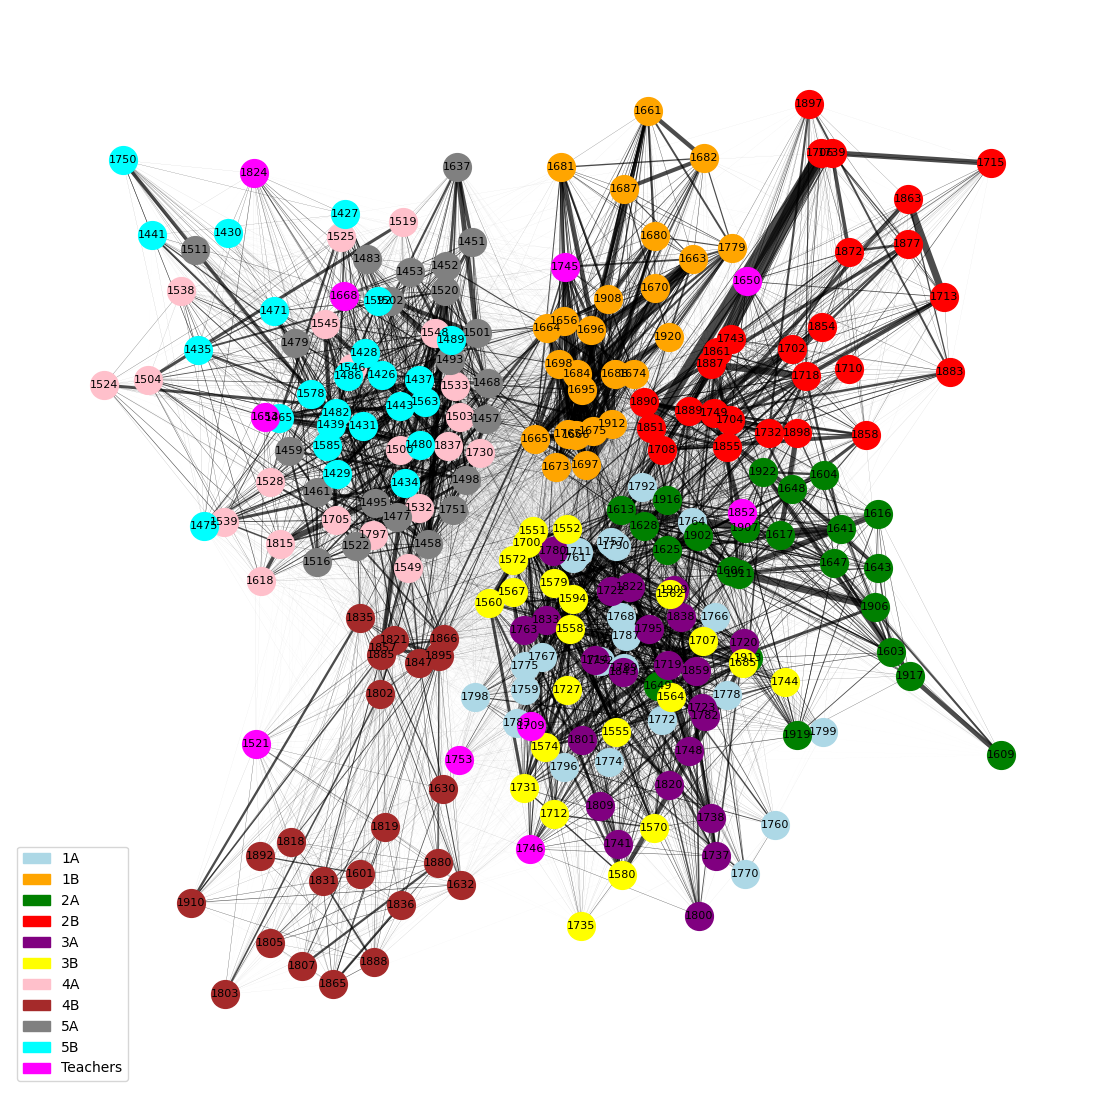

In [75]:
G = nx.Graph()

# Construction du graphe
for (i, j), group in df.groupby([1, 2]):
    Si, Sj = group[3].iloc[0], group[4].iloc[0]   # catégories
    total_t = group[0].sum()                       # somme des temps de contact

    # Ajouter les noeuds et arêtes
    G.add_nodes_from([
        (i, {"category": Si}),
        (j, {"category": Sj})
    ])
    G.add_edge(i, j, t=total_t)

# Couloration des noeuds par catégories

color_map = {
    "1A": "lightblue",   
    "1B": "orange",      
    "2A": "green",     
    "2B": "red",
    "3A": "purple",
    "3B": "yellow",
    "4A": "pink",
    "4B": "brown",
    "5A": "gray",
    "5B": "cyan",
    "Teachers": "magenta"
    
}
node_colors = [color_map.get(G.nodes[n]["category"], "black") for n in G.nodes()]

# Layout du graphe

pos = nx.spring_layout(G, seed=42)  # Calculer le layout une seule fois

# Ponderation sur les arêtes

edge_weights = [G[u][v]["t"] for u, v in G.edges()]
max_w = max(edge_weights) or 1
edge_widths = [10 * (w / max_w) for w in edge_weights]

# Construction  du graphe

plt.figure(figsize=(14, 14))
nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.7)
for cat, color in color_map.items():
    nodes = [n for n, attr in G.nodes(data=True) if attr["category"] == cat]
    nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_color=color, node_size=400, label=cat)

nx.draw_networkx_labels(G, pos, font_size=8)

# Ajouter la légende
legend_handles = [mpatches.Patch(color=color, label=cat) for cat, color in color_map.items()] # Créer des patches pour la légende(rectangles de couleur)
plt.legend(handles=legend_handles, loc='best')
plt.axis("off")
plt.show()

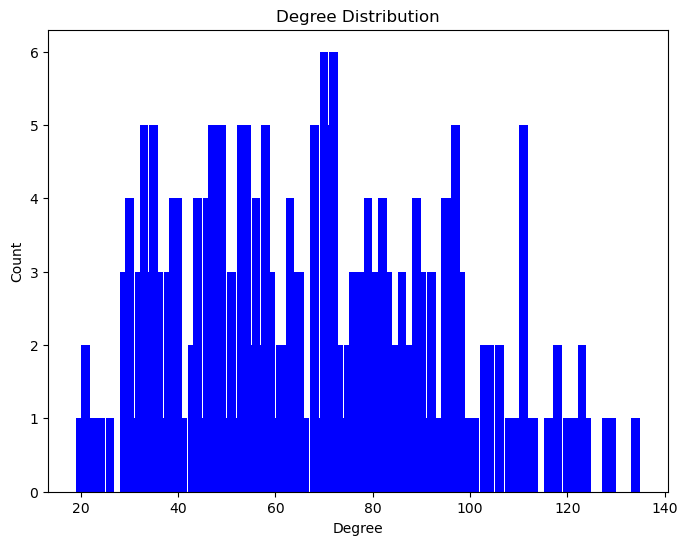

In [80]:
from collections import Counter

# Degré de chaque noeud
degree_sequence = [d for n, d in G.degree()]

# Distribution des degrés
degree_count = Counter(degree_sequence)
deg, cnt = zip(*degree_count.items())

plt.figure(figsize=(8, 6))
plt.bar(deg, cnt, width=1.8, color='blue')
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Count")
plt.show()

# Calcul des propriétés du graphe

In [ ]:
# --- Centralités pondérées ---
degree = dict(G.degree(weight="t"))

betw = nx.betweenness_centrality(G, weight="t", normalized=True)

# closeness → distance = 1 / poids
#  pour que "plus de contact = distance plus courte", on inverse)
G_for_closeness = G.copy()
for u, v, d in G_for_closeness.edges(data=True):
    d["inv_t"] = 1 / d["t"]

close = nx.closeness_centrality(G_for_closeness, distance="inv_t")

pagerank = nx.pagerank(G, weight="t")

avg_neigh_deg = nx.average_neighbor_degree(G, weight="t")

katz = nx.katz_centrality_numpy(G, weight="t", alpha=0.1, beta=1.0) 

df_cent = pd.DataFrame({
    "node": list(G.nodes()),
    "category": [G.nodes[n]["category"] for n in G.nodes()],
    "degree": [degree[n] for n in G.nodes()],
    "betweenness": [betw[n] for n in G.nodes()],
    "closeness": [close[n] for n in G.nodes()],
    "pagerank": [pagerank[n] for n in G.nodes()],
    "avg_neighbor_degree": [avg_neigh_deg[n] for n in G.nodes()],
    "katz": [katz[n] for n in G.nodes()]
})

df_cent.head()

,node,category,degree,betweenness,closeness,pagerank,avg_neighbor_degree,katz
0,1426,5B,91508200,0.000726,1.580695e+06,0.004511,74.572172,0.107259
1,1427,5B,61967460,0.000346,1.451150e+06,0.003197,73.275396,0.071321
2,1428,5B,56009580,0.005066,1.409434e+06,0.002910,80.567970,-0.235038
3,1429,5B,91715660,0.009682,1.407795e+06,0.004469,75.425789,0.007972
4,1430,5B,8642180,0.007158,6.767248e+05,0.001008,68.867439,0.404026


# Detection des communautés

In [90]:
from networkx.algorithms.community import greedy_modularity_communities

communities = greedy_modularity_communities(G, weight="t")

for idx, com in enumerate(communities):
    print(f"Communauté {idx+1}: {len(com)} nœuds")
    for node in com:
        G.nodes[node]['community'] = idx + 1  # Attribuer la communauté au nœud     


Communauté 1: 50 nœuds
Communauté 2: 48 nœuds
Communauté 3: 47 nœuds
Communauté 4: 47 nœuds
Communauté 5: 26 nœuds
Communauté 6: 24 nœuds


In [89]:
from collections import defaultdict

comm_dict = defaultdict(list)
for n in G.nodes():
    comm_dict[G.nodes[n]['community']].append(n)

for comm, nodes in comm_dict.items():
    print(f"\n🔵 Communauté {comm} ({len(nodes)} nœuds)")
    print(nodes)



🔵 Communauté 3 (47 nœuds)
[1426, 1427, 1428, 1429, 1430, 1431, 1435, 1437, 1439, 1441, 1443, 1451, 1452, 1457, 1458, 1459, 1465, 1468, 1471, 1475, 1477, 1480, 1482, 1483, 1486, 1489, 1493, 1498, 1501, 1502, 1511, 1516, 1520, 1522, 1563, 1578, 1585, 1592, 1750, 1751, 1824, 1453, 1461, 1479, 1668, 1495, 1637]

🔵 Communauté 4 (47 nœuds)
[1434, 1500, 1525, 1528, 1532, 1533, 1545, 1548, 1630, 1705, 1730, 1797, 1837, 1866, 1885, 1895, 1549, 1802, 1821, 1847, 1857, 1503, 1521, 1653, 1815, 1819, 1539, 1835, 1519, 1546, 1632, 1880, 1504, 1618, 1601, 1805, 1831, 1888, 1818, 1865, 1892, 1836, 1807, 1524, 1538, 1803, 1910]

🔵 Communauté 1 (50 nœuds)
[1551, 1552, 1558, 1564, 1574, 1700, 1780, 1782, 1833, 1707, 1709, 1560, 1567, 1579, 1714, 1572, 1723, 1731, 1722, 1795, 1909, 1712, 1763, 1822, 1838, 1843, 1889, 1562, 1594, 1719, 1702, 1727, 1555, 1738, 1741, 1801, 1809, 1859, 1820, 1570, 1748, 1746, 1720, 1854, 1580, 1685, 1737, 1744, 1800, 1735]

🔵 Communauté 2 (48 nœuds)
[1628, 1708, 1749, 1902, 